# Evaluation

In [2]:
import json
import torch
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from dinov2.models.vision_transformer import DinoVisionTransformer, vit_large
from dinov2.models.vision_transformer import vit_base
from torchvision.transforms import ToTensor,ToPILImage

/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [16]:
def extract_max_knn_performance(file_path):
    max_accuracy = None
    with open(file_path, "r") as file:
        for line in file:
            data = json.loads(line)
            for value in data.values():
                if max_accuracy is None or value > max_accuracy:
                    max_accuracy = value
    return max_accuracy if max_accuracy is not None else None

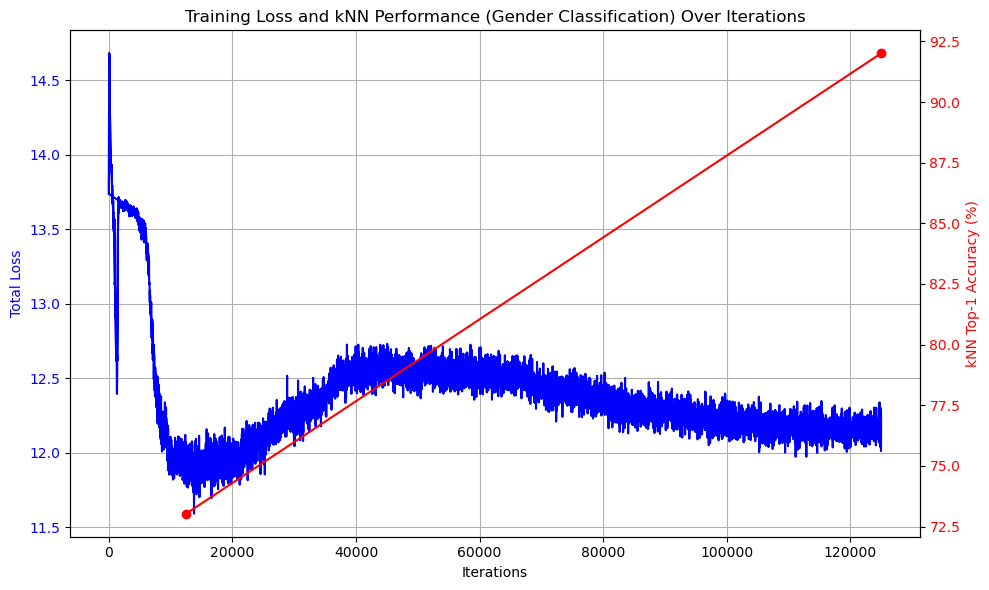

In [18]:
metrics_file = "./CelebA_gt/training_metrics.json"
knn_files = {
    12499: "./CelebA_gt/eval/training_12499/knn_gender_with_original_val_dataset/results_eval_knn.json",
    124999: "./CelebA_gt/eval/training_124999/knn_gender_with_original_val_dataset/results_eval_knn.json",
}
knn_points = {
    checkpoint: extract_max_knn_performance(path)
    for checkpoint, path in knn_files.items()
}

with open(metrics_file, "r") as file:
    metrics = [json.loads(line) for line in file]

iterations = [entry["iteration"] for entry in metrics]
total_loss = [entry["total_loss"] for entry in metrics]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(iterations, total_loss, label="Total Loss", color="blue")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Total Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

ax2 = ax1.twinx()
checkpoints = list(knn_points.keys())
knn_accuracies = list(knn_points.values())
ax2.plot(checkpoints, knn_accuracies, label="kNN Top-1 Accuracy", color="red", marker="o", linestyle="-")
ax2.set_ylabel("kNN Top-1 Accuracy (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Training Loss and kNN Performance (Gender Classification) Over Iterations")
fig.tight_layout()

plt.show()

**Comment:** Loss curve is similar to: https://github.com/facebookresearch/dinov2/issues/143#issuecomment-1651732518
TODO: Perform knn- and linear evaluation for each teacher checkpoint and plot the results. Then compare it with image retrieval performance.

## Instance Retrieval

In [1]:
import torch
import json
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

### Example

In [2]:
query_image_name = "162771.jpg"
embeddings_file = "./embeddings/CelebA_gt_CelebAOriginalVal_emb.json"

In [3]:
def load_embeddings(file_path):
    with open(file_path, "r") as f:
        embeddings_data = json.load(f)
    embedding_names = list(embeddings_data.keys())
    embedding_vectors = np.array([embeddings_data[name] for name in embedding_names])
    return embedding_names, embedding_vectors

In [4]:
def visualize_top_k_results(query_image, top_k_paths, top_k_scores):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(top_k_paths) + 1, 1)
    plt.imshow(query_image)
    plt.axis("off")
    plt.title("Query Image")

    for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=2):
        img = Image.open(path)
        plt.subplot(1, len(top_k_paths) + 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Score: {score:.4f}")

    plt.show()

In [5]:
embedding_names, embedding_vectors = load_embeddings(embeddings_file)

if query_image_name not in embedding_names:
    raise ValueError(f"Query image '{query_image_name}' not found in embeddings file.")
query_embedding_np = np.array([embedding_vectors[embedding_names.index(query_image_name)]])

Top-5 Retrieval Results:
1. 162771.jpg (Score: 1.0000)
2. 169541.jpg (Score: 0.6865)
3. 172220.jpg (Score: 0.6435)
4. 178708.jpg (Score: 0.6379)
5. 181258.jpg (Score: 0.6107)


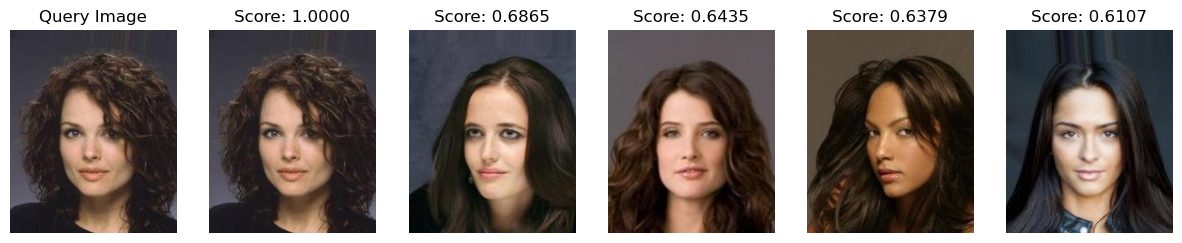

In [6]:
similarities = cosine_similarity(query_embedding_np, embedding_vectors)

top_k = 5
sorted_indices = np.argsort(similarities[0])[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_paths = [Path("./dinov2/data/datasets/CelebA/CelebA_original/val") / embedding_names[idx] for idx in top_k_indices]
top_k_scores = [similarities[0][idx] for idx in top_k_indices]

query_image_path = Path(f"./dinov2/data/datasets/CelebA/CelebA_original/val/{query_image_name}")
query_image = Image.open(query_image_path).convert("RGB")

print("Top-5 Retrieval Results:")
for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=1):
    print(f"{i}. {path.name} (Score: {score:.4f})")

visualize_top_k_results(query_image, top_k_paths, top_k_scores)

### Create Ground Truth Retrieval Files

#### CelebA

In [7]:
embedding_names, embedding_vectors = load_embeddings(embeddings_file)

In [8]:
ground_truth_retrievals = {}

for idx, query_image_name in enumerate(tqdm(embedding_names, desc="Processing images")):
    query_embedding = embedding_vectors[idx].reshape(1, -1) # (n_features,) -> (1, n_features)
    similarities = cosine_similarity(query_embedding, embedding_vectors)[0]

    sorted_indices = np.argsort(similarities)[::-1]
    retrieval_results = [
        {embedding_names[i]: float(similarities[i])} for i in sorted_indices # e.g., [{"162772.jpg": 1.0000}, {"179593.jpg": 0.5398}, {"174813.jpg": 0.5394}, ...]
    ]

    ground_truth_retrievals[query_image_name] = retrieval_results # e.g., {"162772.jpg": [{"162772.jpg": 1.0000}, {"179593.jpg": 0.5398}, {"174813.jpg": 0.5394}, ...]}

# Better save as .pkl-file to save disk space.
#output_file = "./retrieval_ground_truths/CelebA_retrieval_ground_truths.json"
#with open(output_file, "w") as f:
#    json.dump(ground_truth_retrievals, f, indent=4)
#
# print(f"Ground-Truth Retrievals saved to {output_file}.")

Processing images: 100%|██████████| 19792/19792 [42:52<00:00,  7.69it/s]  


Ground-Truth Retrievals saved to ./retrieval_ground_truths/CelebA_retrieval_ground_truths.json.


In [10]:
pickle_file = "./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl"

with open(pickle_file, "wb") as f:
    pickle.dump(ground_truth_retrievals, f)

print(f"Ground-Truth Retrievals saved to {pickle_file}.")

Ground-Truth Retrievals saved to ./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl.


In [2]:
pickle_file = "./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl"

with open(pickle_file, "rb") as f:
    ground_truth_retrievals = pickle.load(f)

In [3]:
query_image_name = "162771.jpg"

if query_image_name in ground_truth_retrievals:
    retrieval_results = ground_truth_retrievals[query_image_name]
    print(f"Retrieval results for {query_image_name}:")
    for result in retrieval_results[:5]:
        print(result)
else:
    print(f"No retrieval results found for {query_image_name}.")

Retrieval results for 162771.jpg:
{'162771.jpg': 1.0000000000000007}
{'169541.jpg': 0.6864995842803154}
{'172220.jpg': 0.6434831102829659}
{'178708.jpg': 0.6379220841799479}
{'181258.jpg': 0.6106827531017711}
